In [1]:
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse
from pylab import*

In [2]:
def SO2_from_params(theta):
    return array([
        [cos(theta), -sin(theta)],
        [sin(theta), cos(theta)]])

def SE2_from_params(theta, x, y):
    return array([
        [cos(theta), -sin(theta), x],
        [sin(theta), cos(theta), y],
        [0, 0, 1]])

def SE2_to_params(X):
    assert X.shape == (3, 3)
    theta = arctan2(X[1, 0], X[0, 0])
    return array([theta, X[0, 2], X[1, 2]])

def SE2_inv(X):
    theta, x, y = SE2_to_params(X)
    R_T = SO2_from_params(theta).T
    v = -R_T@[x, y]
    return array([
        [R_T[0, 0], R_T[0, 1], v[0]],
        [R_T[1, 0], R_T[1, 1], v[1]],
        [0, 0, 1]])

def SE2_wedge(v):
    assert v.shape == (3,)
    return array([
        [0, -v[0], v[1]],
        [v[0], 0, v[2]],
        [0, 0, 0]])

def SE2_vee(a):
    assert a.shape == (3,3)
    return array([a[1,0], a[0,2], a[1,2]])

def SE2_exp_wedge(a):
    assert a.shape == (3,)
    alpha = a[0]
    u1 = a[1]
    u2 = a[2]
    if alpha < pi/18:
        t1 = 1 - alpha**2/6 + alpha**4/120
        t2 = alpha/2 - alpha**3/24 - alpha**5/720
    else:
        t1 = sin(alpha)/alpha
        t2 = 1-cos(alpha)/alpha
    x = array([[t1, -t2],
               [t2, t1]])@[u1,u2]
    return SE2_from_params(alpha, x[0], x[1])

def SE2_Ad(v):
    assert v.shape == (3,)
    return array(
        [[0,     0,     0],
         [0,     0, -v[0]],
         [-v[1], v[0], 0]])

In [3]:
def iekf(tf, vt, x0, P0, dt, xh0):

    # left invariant error in exponential coordinate
    X = SE2_from_params(*x0)  # reference
    
    # Initial Condition
    X_h = SE2_from_params(*xh0)  # estimate
    P = P0  # covariance in Lie Algebra
    Q = diag([(pi/180)**2,1e-4,1e-4])
    A = -SE2_Ad(vt)
    n_steps = int(tf/dt)  # number of steps
    Vn_cov = 0.01*eye(2)
    ita = eye(3)
    H = array([[0, 1, 0],
               [0, 0, 1]])
        
    # output data for plotting
    out_x = []    # Lie Group parans reference
    out_xe = []   # Lie Group params estimate
    out_t = []  # time
    
    for i in range(n_steps):
        
        # store data
        out_xe.append(SE2_to_params(X_h))
        out_x.append(SE2_to_params(X))
        out_t.append(dt*i)

        # Propagate Reference Trajectory
        X = X@SE2_exp_wedge(vt*dt)
        
        # Propagate Estimate
        X_h = X_h@SE2_exp_wedge(vt*dt)
        
        # Propagate Estimate Covariance
        P = P + (A@P+P@A.T+Q)*dt
        
        # Measurement at 1 Hz
        if i%100 == 0:                
            #iekf Gain
            Vn = np.random.multivariate_normal(zeros(2), Vn_cov)

            R = X_h[0:2,0:2]
            N = R@Vn_cov@R.T
            S = H@P@H.T + N
            Ln = P@H.T@inv(S) # Gain
            Lnr = Ln@[[1, 0, 0],[0, 1, 0]]
            
            # simulated measurement
            Y = X@[0, 0, 1] + np.append(Vn,[0])
            
            correction = Lnr@(SE2_inv(X_h)@Y - [0, 0, 1])
            X_h = X_h@SE2_exp_wedge(correction)

            # Covariance Measurement Update
            P = (eye(3) - Ln@H)@P

    t = np.array(out_t)
    xe = np.array(out_xe)
    x = np.array(out_x)
    return t, xe, x

In [4]:
tf = 40
v = 0.7
r = 5
omega = v /r

vt = array([omega, v, 0])  # velocity, omega
x0 = array([pi/2, 0, 0])
xh0 = array([pi/4, 0, 0]) # initial error
P0 = diag([(45*pi/180)**2, 0.1, 0.1])
dt = 0.01
t, xe, x = iekf(tf, vt, x0, P0, dt, xh0)

In [5]:
xe.shape

(4000, 3)

# Figure 1

(-0.5, 509.5, 413.5, -0.5)

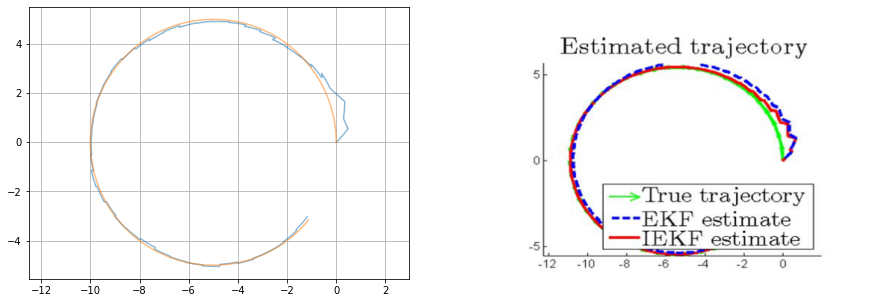

In [6]:
figure(figsize=(15,5))
subplot(121)
plot(xe[:, 1], xe[:, 2], label='estimated', alpha=0.5)
plot(x[:, 1], x[:, 2], label = 'reference', alpha=0.5)
grid()
axis('equal');
subplot(122)
imshow(imread('./images/fig1.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 2

In [7]:
error_att = []
for i in range(step):
    error_theta = math.acos(ita[i][0][0])*180/pi
    error_att.append(error_theta)

TypeError: 'function' object cannot be interpreted as an integer

In [ ]:
err_att = []
windowsize = 100
for j in range(len(error_att) - windowsize +1):
    err_att_avg = sum(error_att[j:j+windowsize])/windowsize
    err_att.append(err_att_avg)

In [ ]:
t_x = np.linspace(0, t, len(err_att))
figure(figsize=(15,5))
subplot(121)
plot(t_x, err_att)
subplot(122)
imshow(imread('./images/fig2.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 3

In [ ]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

In [ ]:
err = []
for j in range(len(error) - windowsize +1):
    err_avg = sum(error[j:j+windowsize])/windowsize
    err.append(err_avg)

In [ ]:
figure(figsize=(15,5))
subplot(121)
plot(t_x ,err)
subplot(122)
imshow(imread('./images/fig3.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

In [ ]:
t = 40
vt = [.7, .14]
x0 = [pi/2,0,0]
Xi0 = array([pi/180,0,0]).T # initial error
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.01
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt, Xi0)

# Figure 4

In [ ]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

In [ ]:
m = 10
e_x = []
e_y = []
r_x = []
r_y = []
for j in range(int(len(xe_x)/m)-1):
    xe_x_avg = sum(xe_x[j*10:(j+1)*m])/m
    e_x.append(xe_x_avg)
    xe_y_avg = sum(xe_y[j*10:(j+1)*m])/m
    e_y.append(xe_y_avg)
    xr_x_avg = sum(xr_x[j*10:(j+1)*m])/m
    r_x.append(xr_x_avg)
    xr_y_avg = sum(xr_y[j*10:(j+1)*m])/m
    r_y.append(xr_y_avg)

In [ ]:
figure(figsize=(15,5))
subplot(121)
plot(e_x,e_y, label='estimated')
plot(r_x,r_y, label = 'reference')
axis('equal');
subplot(122)
imshow(imread('./images/fig4.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 5

In [ ]:
error_att = []
for i in range(step):
    error_theta = math.acos(ita[i][0][0])*180/pi
    error_att.append(error_theta)

In [ ]:
err_att = []
windowsize = 100
for j in range(len(error_att) - windowsize +1):
    err_att_avg = sum(error_att[j:j+windowsize])/windowsize
    err_att.append(err_att_avg)

In [ ]:
t_x = np.linspace(0, t, len(err_att))
figure(figsize=(15,5))
subplot(121)
plot(t_x, err_att)
subplot(122)
imshow(imread('./images/fig5.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 6

In [ ]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

In [ ]:
err = []
for j in range(len(error) - windowsize +1):
    err_avg = sum(error[j:j+windowsize])/windowsize
    err.append(err_avg)

In [ ]:
figure(figsize=(15,5))
subplot(121)
plot(t_x ,err)
subplot(122)
imshow(imread('./images/fig6.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')